# Numerical solution of the Fokker-Planck Equation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

#### The Fokker Planck equation for the phase space probability distribution of the noisy harmonic oscillator reads
$$
\frac{\partial w(\xi_i,t)}{\partial t}=-D_i\frac{\partial w(\xi_i,t)}{\partial\xi_i}+
D_{ij}\frac{\partial^2 w(\xi_i,t)}{\partial\xi_i\partial\xi_j}
$$
with the vector $\mathbf{\xi}=(x,v)^T$

#### In the case of a harmonic oscillator we have
$$
\frac{\partial w(x,v,t)}{\partial t}=-v\frac{\partial w(x,v,t)}{\partial x}+
(x+\gamma v)\frac{\partial w(x,v,t)}{\partial v}+\gamma w(x,v,t)+
c\frac{\partial^2 w(x,v,t)}{\partial v^2}
$$
In terms of finite differences with Euler forward we have
$$
w(x,v,t+\Delta t)=(1+\gamma\cdot\Delta t)\cdot w(x,v,t)-v\frac{w(x+\Delta x,v,t)-w(x-\Delta x,v,t)}{2\Delta x}
+(x+\gamma v)\frac{w(x,v+\Delta v,t)-w(x,v-\Delta v,t)}{2\Delta v}
+c\frac{w(x,v+\Delta v,t)-2\cdot w(x,v,t)+w(x,v-\Delta v,t)}{\Delta v^2}
$$

In [553]:
bins = 200

x, v = np.meshgrid(np.linspace(-1, 1, bins), np.linspace(-1, 1, bins))
wxv = np.zeros((bins, bins))

mu = 1

v_ = mu * (1 - x ** 2) * v - x

wxv[75:125, 0:50] = 100

<IPython.core.display.Javascript object>


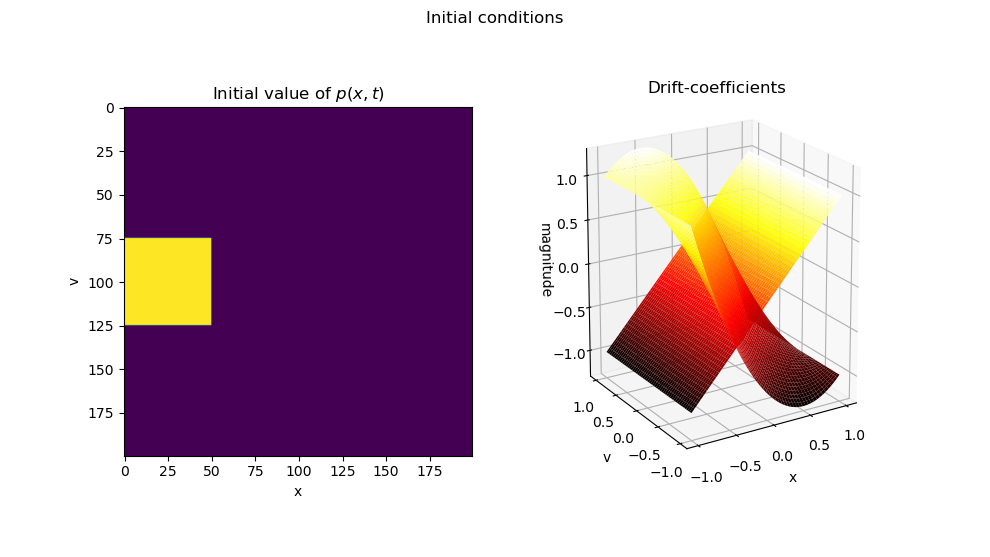

In [147]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('Initial conditions')

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Initial value of $p(x, t)$')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.imshow(wxv)
#ax.colorbar()

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('Drift-coefficients')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('magnitude')
ax.plot_surface(x, v, x, label='x', cmap='hot')
ax.plot_surface(x, v, v_, label='v', cmap='hot')
#ax.legend()

plt.show()

In [381]:
%matplotlib notebook
# HO FPE
dt = 0.1
gamma = 0.01
c = 1.0
k = 1.0
m = 1.0

for i in np.arange(100000):
    dwdx = (np.roll(wxv, -1, 1) - np.roll(wxv, 1, 1)) / 2.
    dwdv = (np.roll(wxv, -1, 0) - np.roll(wxv, 1, 0)) / 2.
    d2wdv2 = np.roll(wxv, -1, 0) - 2. * wxv + np.roll(wxv, 1, 0)
    # boundary condition 0
    wxv[1:-2,1:-2] = ((1.0 + gamma * dt) * wxv - v * dwdx * dt + (x + gamma * v) * dwdv * dt + c * d2wdv2 * dt)[1:-2,1:-2]
    # no boundary condition
    #wxv = ((1.0 + gamma * dt) * wxv - v * dwdx * dt + (x + gamma * v) * dwdv * dt + c * d2wdv2 * dt)

#### VdP

In [554]:
frames = []

In [555]:
%matplotlib notebook
# VdP FPE
dt = .1
gamma = 0.01

c = 1.0
#mu = 2

for i in np.arange(100000):
    if i % 1000 == 0 or (i < 2000 and i % 100 == 0):
        frames.append(wxv * 1)
    dwdx = (np.roll(wxv, -1, 1) - np.roll(wxv, 1, 1)) / 2.
    dwdv = (np.roll(wxv, -1, 0) - np.roll(wxv, 1, 0)) / 2.
    d2wdv2 = np.roll(wxv, -1, 0) - 2. * wxv + np.roll(wxv, 1, 0)

    wxv[1:-2,1:-2] = ((1.0 + gamma * (mu*(1-x**2)) * dt) * wxv - dwdx * v * dt - dwdv * (mu * (1 - x ** 2) * v - x) * dt\
                      + c * d2wdv2 * dt)[1:-2,1:-2]

<IPython.core.display.Javascript object>


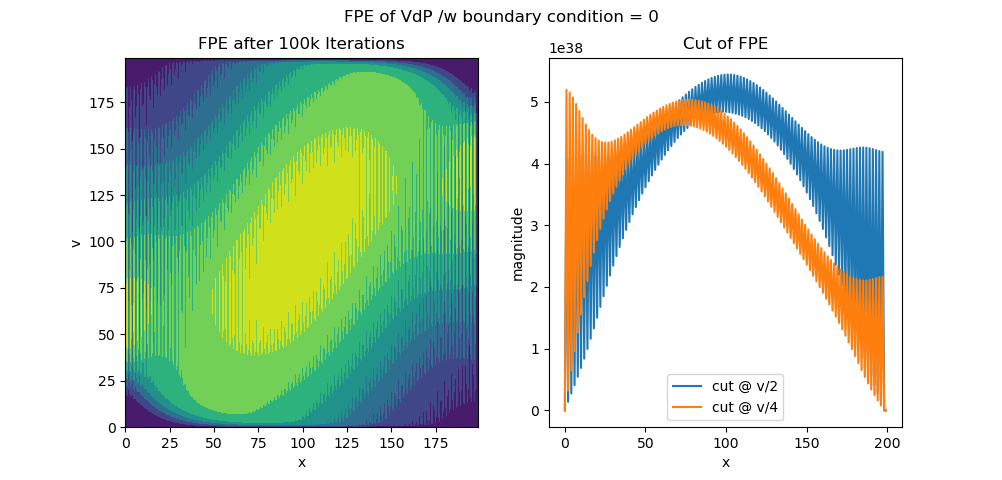

In [556]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('FPE of VdP /w boundary condition = 0')

ax = fig.add_subplot(1, 2, 1)
ax.set_title('FPE after 100k Iterations')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.contourf(wxv)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Cut of FPE')
ax.set_xlabel('x')
ax.set_ylabel('magnitude')
ax.plot(wxv[100], label='cut @ v/2')
ax.plot(wxv[50], label='cut @ v/4')
ax.legend()

plt.show()

##### Animation

In [358]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


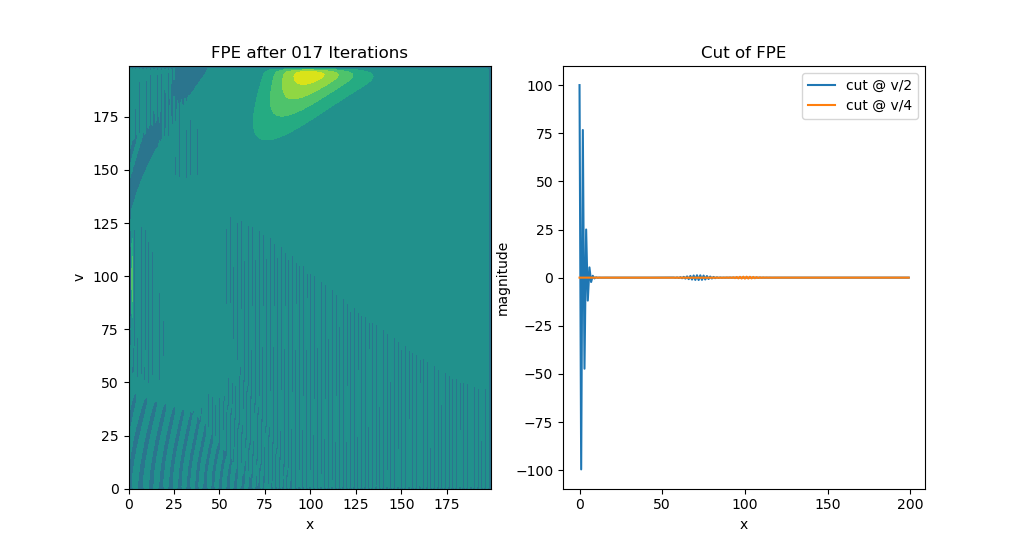

118


In [557]:
fig, ax = plt.subplots()

print(len(frames))

def animate(i):
    '''ax.clear()
    ax.imshow(frames[i])
    ax.set_title('Iteration: %03d'%(i))
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    #plt.savefig('fig_' + str(i) + '.png')'''
    fig.clear()
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('FPE after %03d Iterations'%(i))
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    ax.contourf(frames[i])

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('Cut of FPE')
    ax.set_xlabel('x')
    ax.set_ylabel('magnitude')
    ax.plot(frames[i][100], label='cut @ v/2')
    ax.plot(frames[i][50], label='cut @ v/4')
    ax.legend()
    
interval = 100
ani = animation.FuncAnimation(fig, animate, interval=interval, blit=False, frames=len(frames), repeat_delay=1000)

plt.show()